In [9]:
import sys
sys.path.insert(0, '../')
import numpy as np
import matplotlib.pyplot as plt
from src.ModelClasses import CellType, Water, Solute, Grid, BoundSolute
from src.ModelSetup import Nondimensionalise, CalculateTimestep
from src.TimestepManager import Timestep
from tqdm import tqdm
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.5)

In [10]:
# --------------------------------------  MODEL SETUP

# grid parameters
nx = 40
ny = 40

# domain size is reduced to 1/3 to reduce computational load for testing, i.e. L, H = 1e-3 instead of 3e-3
grid = Grid(T = 1e5, L = 1e-3, H = 1e-3, nx = nx, ny = ny, h=1/(3*nx))
cell = CellType(diffusion_rate = 1e-14, initial_volume_fraction = 0.05, chemotaxis_strength=1.36, bound_chemotaxis_strength=42.4, matrix_drag=9.89e9, matrix_traction=0, contact_inhibition=0.0, aggregation_strength=0)
water = Water(matrix_volume_fraction=0.03, matrix_drag=5e7)
solute = Solute(diffusion_rate = 1e-11, initial_solute_concentration = 0, production_rate=8.74e-11, uptake_rate=0, degradation_rate=8.21e-4, binding_rate=1.5e-3)
bound_solute = BoundSolute(initial_solute_concentration = 0, degradation_rate=8.21e-4, unbinding_rate=3.7e-3)

# Set initial distributions
multiplier = int(nx/10)
np.random.seed(45) #fix noise distribution to be the same every time
cell.distribution = cell.initial_volume_fraction + np.random.normal(0, 0.1*cell.initial_volume_fraction, size = (10, 10))
cell.distribution = np.repeat(cell.distribution, multiplier, axis = 0)
cell.distribution = np.repeat(cell.distribution, multiplier, axis = 1)
water.distribution = water.available_volume_fraction - cell.distribution

cell.x_velocity = np.zeros((grid.nx, grid.ny))
cell.y_velocity = np.zeros((grid.nx, grid.ny))

solute.distribution = solute.uniform_solute_distribution(water, grid)
bound_solute.distribution = bound_solute.uniform_solute_distribution(water, grid)

initial_cell_distribution = cell.distribution
initial_solute_distribution = solute.distribution

# Nondimensionalise the input parameters

grid.L = 3e-3 # set lengthscale to 3mm for nondimensionalisation to match paper
Nondimensionalise(cell, solute, bound_solute, water, grid, cM = 1e-9, cell_viscosity = 1e4)

In [11]:
timestep_sizes = [5e-5, 1e-4, 1.5e-4, 2e-4, 3e-4, 4e-4, 6e-4, 8e-4, 1e-3]

cell_outputs = []
cell_cons_errors = []
    
for timestep in timestep_sizes:

    # Calculate number of timesteps required to reach Tmax
    dt = timestep
    Tmax = 0.1
    nsteps = int(Tmax/dt)
    print(nsteps)

    # Run the model

    cons_init = np.sum(cell.distribution)

    for t in tqdm(range(nsteps+1)):
        Timestep(cell, solute, bound_solute, water, grid, dt)

    # Calculate conservation error

    cons_final = np.sum(cell.distribution)

    print('cons_error =', (cons_final - cons_init)/cons_init)
    cell_cons_errors.append((cons_final - cons_init)/cons_init)

    # Save average cell volume fraction for each timestep size

    nx = grid.nx
    ny = grid.ny

    cell_outputs.append(np.sum(cell.distribution)/(nx*ny))


  0%|          | 0/2001 [00:00<?, ?it/s]

2000


  0%|          | 0/1001 [00:00<?, ?it/s]

cons_error = -0.00010272384453935692
1000


  0%|          | 0/667 [00:00<?, ?it/s]

cons_error = -0.00019194506204591802
666


  0%|          | 0/501 [00:00<?, ?it/s]

cons_error = -0.00022648219719946804
500


  0%|          | 0/334 [00:00<?, ?it/s]

cons_error = -0.0002653205540226489
333


  0%|          | 0/251 [00:00<?, ?it/s]

cons_error = -0.0003030412785281114
250


  0%|          | 0/167 [00:00<?, ?it/s]

cons_error = -0.00033276431227407
166


  0%|          | 0/126 [00:00<?, ?it/s]

cons_error = -0.00034040431201373737
125


  0%|          | 0/101 [00:00<?, ?it/s]

cons_error = -0.00031522349963115877
100


100%|██████████| 101/101 [00:39<00:00,  2.58it/s]

cons_error = -0.00024005549588539655


In [12]:
cells_time_error = []

for i in range(1, len(timestep_sizes)):
    cells_time_error.append(np.abs((cell_outputs[i] - cell_outputs[0])/cell_outputs[0]))
    

In [13]:
logtimes = np.log(timestep_sizes)[1:]
logerrors = np.log(cells_time_error)

# make linspace list for x axis
mx = len(timestep_sizes) - 2
x = np.linspace(logtimes[1], logtimes[mx], 100)

# find line of gradient 1 through one of the points
Ynint = logerrors[mx-1] - 1 * logtimes[mx-1]
Yn = 1 * x + Ynint


Text(0.5, 0, 'log(timestep)')

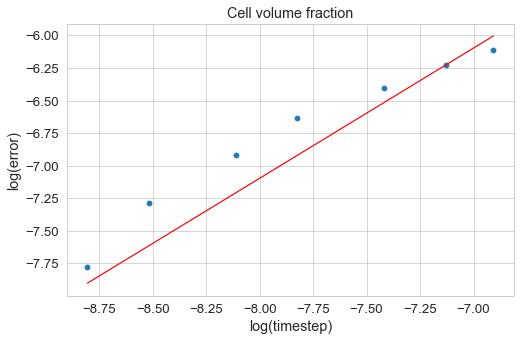

In [14]:
# plot the results 

plt.figure(figsize=(8, 5))
plt.plot(logtimes[1:], logerrors[1:], 'o')
plt.plot(x, Yn, 'r')
plt.title('Cell volume fraction')
plt.ylabel('log(error)')
plt.xlabel('log(timestep)')
#plt.savefig('plots/timestep_convergence.png', dpi=300)



Text(0, 0.5, 'Conservation error [%]')

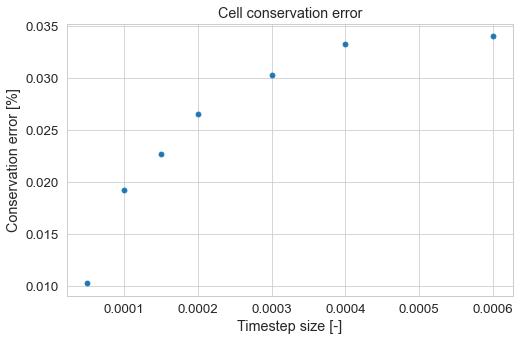

In [15]:
# plot cell conservation error

plt.figure(figsize=(8, 5))
plt.plot(timestep_sizes[:-2], 100*np.abs(cell_cons_errors[:-2]), 'o')
plt.title('Cell conservation error')
plt.xlabel('Timestep size [-]')
plt.ylabel('Conservation error [%]')
#plt.savefig('plots/timestep_conservation.png', dpi = 300)
